In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. CREATE EXAMPLE TIME SERIES

## 1.1 Define required functions

In [5]:
# define function to draw graph
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()


# Function for creating trend in time series
def trend(time, slope=0):
    series = slope * time
    return series


# Function for creating seasonal pattern
def seasonal_pattern(season_time):
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

# Function for adding seasonality
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)
    return data_pattern

# Function for adding some noise
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level
    return noise


## 1.2 Create a time series

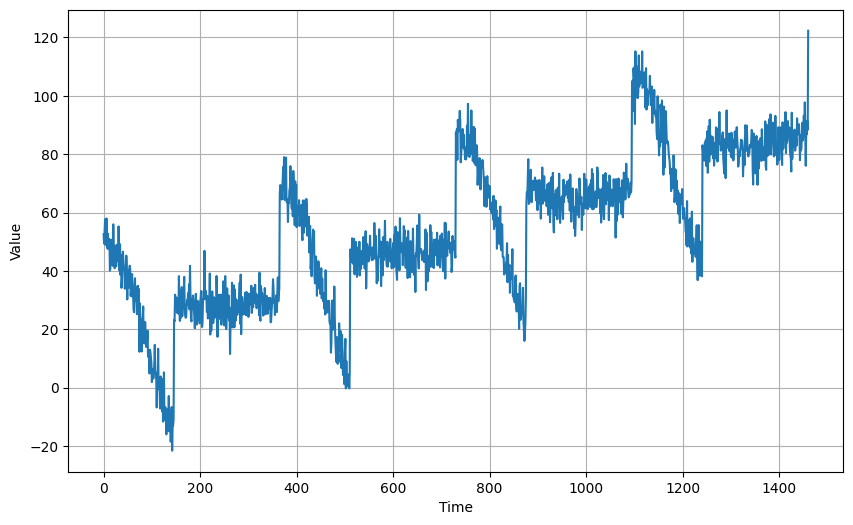

In [6]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# add some noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

# 2. SPLIT TIME SERIES

In [8]:
# Check how many number of data point
num_time_points = time.size
num_series_points = series.size

print(f"Number of time points: {num_time_points}")
print(f"Number of series points: {num_series_points}")

Number of time points: 1461
Number of series points: 1461


- 1000 data points for --> train
- 461 data points for --> validation

In [9]:
# Define the split time
split_time = 1000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# 3. WINDOW DATASET

In [10]:
# Define function foe windowing dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache().prefetch(1)

    return dataset

In [11]:
# Specify parameters for windowed dataset
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

### 🔺 After data split, use x_tarin values for creating windowed dataset

In [ ]:
# Create windowed dataset by using defined function
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# 3. FIND OPTIMUM LEARNING RATE
- Start without determinatio learning rate and see result in the graph (graph of loss change according to teh change of learning rate). Just determine momentum
- Use Learning Rate Scheduler which is one of callbacks methods
- After seeing result, build model again

## 3.1 Build base line model for observation loss change accorind to LR change

In [14]:
# Build model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape = (window_size,)),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

### 🔺 Default learning rate during observation = 1e-8

In [15]:
# create learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [17]:
# compile model, don't determine learning rate
model.compile(loss = "mse",
              optimizer = tf.keras.optimizers.SGD(momentum=0.9))

In [18]:
# train model
history = model.fit(dataset, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 22.0368 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20.4769 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.3001 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.5572 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.4244 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7255 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.6710 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.1791 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.2161 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.0023 - learning_rate: 2.8184e-08
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0508 - learning_rate: 3.1623e-08
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

(1e-08, 0.001, 0.0, 300.0)

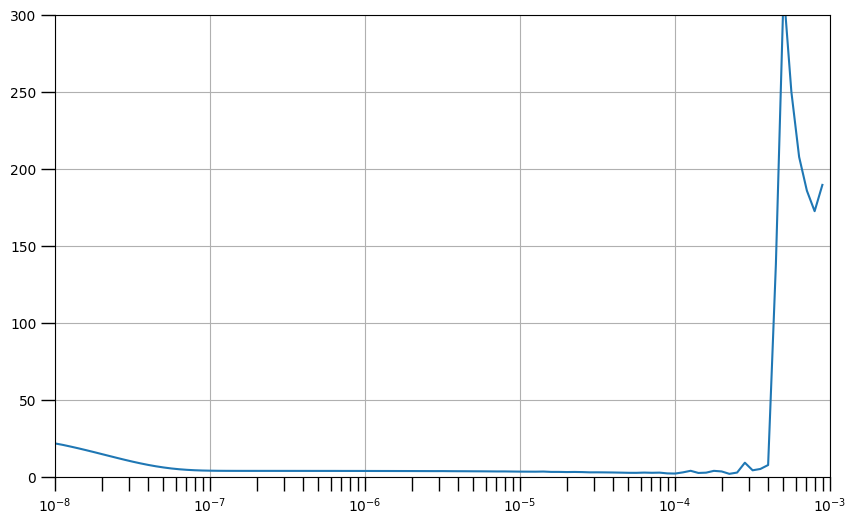

In [19]:
# Graph for observation the change of loss according to the change of learning rate

lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 300])

## Choose learnign rate = 10^-6 = a.e - 6

# 4. BUILD MODEL WITH OPTIMUM LEARNING RATE

In [34]:
# Build model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape = (window_size,)),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

In [35]:
# compile model
model_tune.compile(loss = "mse",
                      optimizer = tf.keras.optimizers.SGD(learning_rate= 4e-6, momentum=0.9))

### 🔺You don't need to add callbacks anymore

In [40]:
# train model
history  = model_tune.fit(dataset, epochs = 100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0969
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1805  
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1273
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9576
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9845
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0731
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0995
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1218
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1545
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0847
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1076
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2176 
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1603 
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0776 
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8488

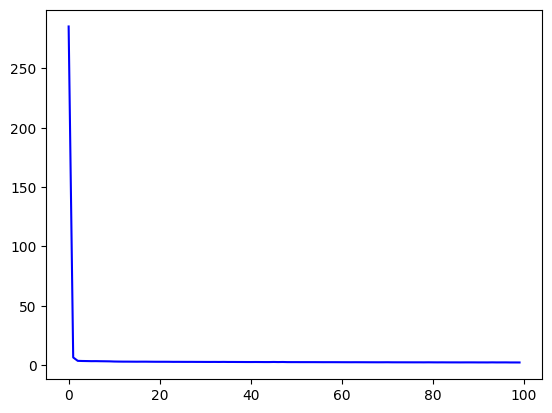

In [37]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

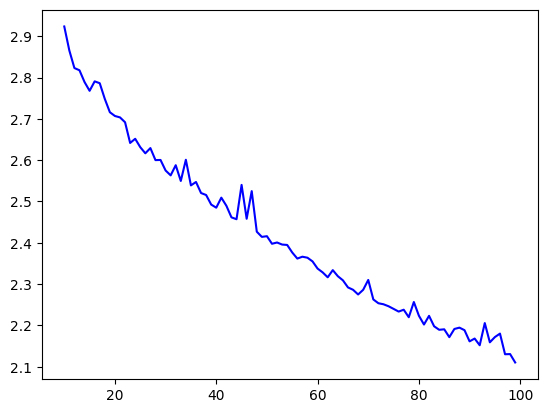

In [39]:
# Plot all but the first 10 to see more clear
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

# 5. TEST WITH VALIDATON SET

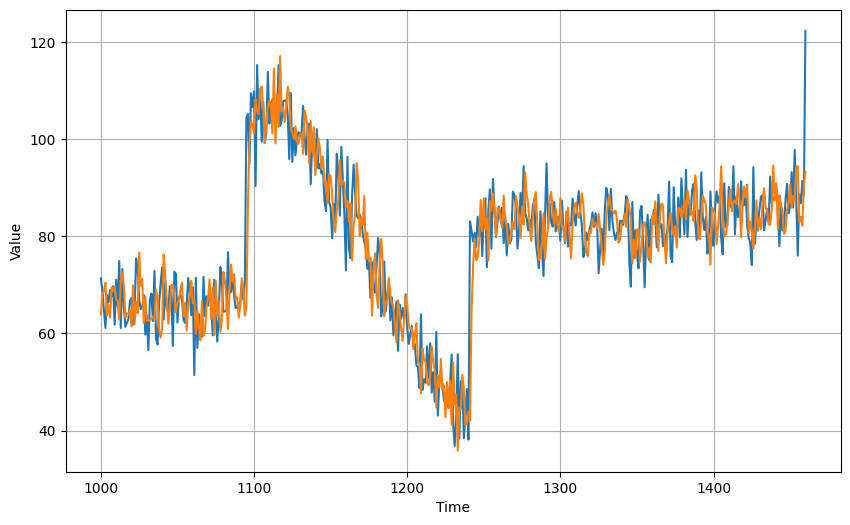

In [41]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Prediction per window size by using model
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [42]:
# See performance metrics
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

53.811245
5.5123315
